# GTEx GWAS Prediction (Evaluation)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import plotnine as p9
import scipy.stats
from plotnine import *
from torcheval.metrics import R2Score
import torch

## Data Preparation

### Load Covariates

In [2]:
def build_control_covariates(metadata):
    genesize = metadata.NPARAM.values.astype(float)
    genedensity = metadata.NPARAM.values/metadata.NSNPS.values
    inverse_mac = 1.0/metadata.MAC.values
    cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
    return cov

def munge_sigma(magma_gene_raw):
    f = open(magma_gene_raw)
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    gene_metadata = []
    gene_lists = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        gene_NSNPs = np.zeros(n_genes)
        gene_NPARAM = np.zeros(n_genes)
        gene_MAC = np.zeros(n_genes)
        for i in range(n_genes):
            line = lines_chr[i]
            gene_NSNPs[i] = line[4]
            gene_NPARAM[i] = line[5]
            gene_MAC[i] = line[7]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
        gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
        gene_metadata.append(gene_metadata_chr)
        gene_list_chr = [line[0] for line in lines_chr]
        gene_lists.append(gene_list_chr)
    return sigmas, gene_metadata, gene_lists

In [3]:
sigmas, metadata, gene_lists = munge_sigma('../../data/HDL_cholesterol.genes.raw')

In [4]:
# create covariates from pops
covariates = []
for i in range(0, 22):
    #print(i)
    covariates.append(pd.DataFrame(build_control_covariates(metadata[i]),
                                   index = gene_lists[i],
                                   columns = ['genesize',
                                              'log_genesize',
                                              'genedensity',
                                              'log_genedensity',
                                              'inverse_mac',
                                              'log_inverse_mac'])
                      )
covariates = pd.concat(covariates)

In [5]:
covariates

,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac
ENSG00000187634,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878
ENSG00000188976,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951
ENSG00000187961,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390
ENSG00000187583,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457
ENSG00000187642,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071
...,...,...,...,...,...,...
ENSG00000008735,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268
ENSG00000100299,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111
ENSG00000251322,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722
ENSG00000100312,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048


### Load Embeddings

In [6]:
#emb_path = '../data/Omics_d256.tsv'
#emb_path = '../data/TabulaSapiens_d128.tsv'
emb_path = '../../data/GTEx_PCA_d64.tsv'

In [7]:
# load embedding
emb = pd.read_csv(emb_path, sep = "\t").set_index("gene_id")
emb

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000204380,-11.444076,2.214697,0.403387,-0.473367,0.155778,-0.038179,-0.083922,-0.261664,0.881155,-0.261164,...,0.053160,0.025038,0.183485,-0.104045,-0.000580,0.035678,0.066887,-0.063483,0.001918,0.078079
ENSG00000265514,-12.586504,2.584671,0.259693,-0.748829,0.068165,-0.025411,-0.105743,-0.109137,0.931237,-0.364536,...,0.134411,0.025051,0.100357,-0.049761,-0.024192,-0.027550,-0.075179,-0.008967,0.090319,0.043576
ENSG00000183696,23.313955,-14.868663,-2.510663,-14.954608,24.633200,4.924134,-5.015983,13.224004,-7.857205,3.296737,...,-3.449555,-2.344337,1.074588,-3.078908,-1.773488,2.713141,1.709083,2.789221,2.704641,0.850577
ENSG00000115297,-12.313880,2.653151,0.251395,-0.720083,-0.006696,-0.042775,-0.092655,-0.168333,0.856357,-0.392655,...,0.154399,0.035460,0.085424,-0.024064,0.052923,0.033322,-0.052409,-0.122530,0.100662,-0.024609
ENSG00000242435,-12.277049,2.364859,0.515145,-0.757522,0.153774,0.001924,-0.102735,-0.113600,1.009397,-0.335274,...,0.132063,0.015846,0.086155,-0.078549,0.007233,-0.006342,-0.012207,-0.044723,0.059886,0.003527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000165023,3.707931,18.179392,-0.730905,2.007968,-1.174206,-3.105570,-0.369488,-9.382309,-27.081612,5.209289,...,-3.148497,-0.385454,0.034638,-0.205486,-2.795644,-0.446885,-2.511616,-1.507201,0.951407,0.659940
ENSG00000266052,-12.659645,2.531429,0.257844,-0.784865,0.117394,-0.019903,-0.106539,-0.073227,0.999967,-0.281757,...,0.154587,0.024300,0.084647,-0.063258,-0.000999,-0.021824,-0.048973,-0.034450,0.068886,0.004147
ENSG00000205670,3.837897,1.809079,-1.878294,2.431991,-1.989821,-1.404669,0.869541,-1.076396,-2.293293,1.030964,...,0.285174,-0.157164,0.098000,0.197747,-0.384215,-0.660348,-0.165807,-0.115973,-0.283561,-0.192346


### Load GWAS MAGMA Scores

In [8]:
magma = pd.read_csv('../../data/HDL_cholesterol.genes.out', delim_whitespace=True)
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050
...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472


### Merge Data

In [9]:
magma = magma.merge(covariates, left_on = "GENE", right_index = True)

In [10]:
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048


### Project Y to LY

In [11]:
def compute_Ls(sigmas, Y):
    Ls = []
    min_lambda=0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    #Y = pd.read_table(args.gene_results+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    return Ls

In [12]:
Ls = compute_Ls(sigmas, magma.ZSTAT)

def project_Y(Ls, magma_Z):
    LYs = []
    for i in range(22):
        L = Ls[i]
        magma_temp = magma.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": magma_temp.GENE, "LY": np.matmul(L, magma_temp.ZSTAT)}))
    return pd.concat(LYs)

def project_Y_back(Ls, res):
    LYs = []
    for i in range(22):
        L = np.linalg.inv(Ls[i])
        temp = res.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": temp.dropna().GENE,
                                 "pred_null": np.matmul(L[~temp.pred_LY_null.isna(), :][:, ~temp.pred_LY_null.isna()],
                                                   temp.dropna().pred_LY_null),
                                 "pred": np.matmul(L[~temp.pred_LY.isna(), :][:, ~temp.pred_LY.isna()],
                                                   temp.dropna().pred_LY),
                                 }))
    return pd.concat(LYs)

magma = magma.merge(project_Y(Ls, magma))

In [13]:
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac,LY
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878,0.999534
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951,1.551349
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390,1.148646
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457,0.708156
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071,1.854531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268,0.512377
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111,1.098611
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722,0.082490
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048,0.569190


### Merge Data

In [14]:
# merge with embedding
dt = magma.merge(emb, left_on = "GENE", right_on = "gene_id")
dt

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,...,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64
0,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,...,-0.032733,0.264043,1.790901,-0.879728,-0.934778,-0.161267,0.712509,-0.745221,0.847064,0.251208
1,ENSG00000186827,1,1146706,1149518,11,4,422405,1.54610,0.061036,4.0,...,-0.758988,0.618775,-0.188342,-0.126129,-0.057670,0.351977,0.393958,0.182957,-0.674566,0.255204
2,ENSG00000157933,1,2160134,2241558,294,52,422405,2.42180,0.007722,52.0,...,-1.939102,-2.057334,0.154393,1.191912,-1.898698,-0.447646,1.601220,2.315905,-2.914213,-2.294888
3,ENSG00000157870,1,2517930,2522908,14,6,422405,1.68330,0.046158,6.0,...,-1.326897,-0.424580,0.695547,0.936621,0.473301,-0.615652,0.404048,-0.358471,0.018947,-0.235786
4,ENSG00000130762,1,3370990,3397677,100,12,422405,0.88493,0.188100,12.0,...,0.595579,0.426738,0.352384,0.717046,-0.531662,-0.781597,-0.490193,-0.880223,-0.664198,0.634452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,ENSG00000100364,22,45586219,45636650,232,31,422405,1.38520,0.083000,31.0,...,-0.770233,-0.404918,1.420373,0.536394,-0.758839,-1.568279,0.060379,0.385907,-0.356227,-0.462703
1604,ENSG00000219438,22,48885272,49246724,2498,169,422405,1.10500,0.134580,169.0,...,-1.422641,0.869798,1.034453,1.076092,-4.845660,-4.718923,-3.393648,-1.035494,1.128941,0.799291
1605,ENSG00000205593,22,50747459,50765489,80,13,422405,0.68918,0.245360,13.0,...,-0.477766,-0.625301,0.825383,0.183494,-0.244560,-0.270465,0.439912,0.724770,-0.665694,-0.193910
1606,ENSG00000205560,22,51007290,51017899,56,10,422405,2.79560,0.002590,10.0,...,-2.531843,-1.694792,0.504150,-0.579786,-2.312156,-1.481255,-0.801417,2.111503,-2.585946,1.537717


## Regression

Split by Chromosomes.

In [15]:
df = []

for chrom in range(1,23):
    reg_null = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
    reg_full = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
    
    # Null model (covariates only)
    mod_null = reg_null.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_null = mod_null.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
    )
    
    # Full model
    mod_full = reg_full.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_full = mod_full.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
    )

    df_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
    df_chrom['pred_LY_null'] = pred_null
    df_chrom['pred_LY'] = pred_full

    df.append(df_chrom)
    print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY_null)[0]**2}")
    print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY)[0]**2}")

print()

df = pd.concat(df)
df = df.merge(project_Y_back(Ls, df))

print(f"Overall R2 (null): {scipy.stats.pearsonr(df.ZSTAT, df.pred_null)[0]**2}")
print(f"Overall R2: {scipy.stats.pearsonr(df.ZSTAT, df.pred)[0]**2}")

Chrom 1: R2 (null): 0.07488773617999459
Chrom 1: R2: 0.08215104620657987
Chrom 2: R2 (null): 0.09969798806061175
Chrom 2: R2: 0.11667788121308863
Chrom 3: R2 (null): 0.024828834930302097
Chrom 3: R2: 0.016681662740144106
Chrom 4: R2 (null): 0.03777412167228434
Chrom 4: R2: 0.03205390119928439
Chrom 5: R2 (null): 0.12045149268819935
Chrom 5: R2: 0.1356605141539216
Chrom 6: R2 (null): 0.02400940680102362
Chrom 6: R2: 0.05312876147993912
Chrom 7: R2 (null): 0.0773863588404105
Chrom 7: R2: 0.05482497838499936
Chrom 8: R2 (null): 0.0350793466316934
Chrom 8: R2: 0.012402225565487928
Chrom 9: R2 (null): 0.05959126870262276
Chrom 9: R2: 0.11098601279808767
Chrom 10: R2 (null): 0.026571189690736748
Chrom 10: R2: 0.05650500558149423
Chrom 11: R2 (null): 0.006845885347178099
Chrom 11: R2: 0.01384225019692284
Chrom 12: R2 (null): 0.023545525613012545
Chrom 12: R2: 0.0261973489838702
Chrom 13: R2 (null): 0.03927574657340511
Chrom 13: R2: 0.07575326462052173
Chrom 14: R2 (null): 0.058197440079158544

In [16]:
df

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,LY,pred_LY_null,pred_LY,pred_null,pred
0,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,0.708156,0.774108,0.778440,1.470242,1.478470
1,ENSG00000186827,1,1146706,1149518,11,4,422405,1.54610,0.061036,0.780465,0.737208,0.743470,1.374267,1.385936
2,ENSG00000157933,1,2160134,2241558,294,52,422405,2.42180,0.007722,1.162777,0.774108,0.778440,1.487269,1.495595
3,ENSG00000157870,1,2517930,2522908,14,6,422405,1.68330,0.046158,0.658944,0.737208,0.721625,1.397200,1.367933
4,ENSG00000130762,1,3370990,3397677,100,12,422405,0.88493,0.188100,0.341941,0.737208,0.743470,1.431411,1.443454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,ENSG00000100364,22,45586219,45636650,232,31,422405,1.38520,0.083000,0.532791,0.790681,0.804442,1.532220,1.558514
1604,ENSG00000219438,22,48885272,49246724,2498,169,422405,1.10500,0.134580,0.416650,0.790681,0.804442,1.519689,1.546139
1605,ENSG00000205593,22,50747459,50765489,80,13,422405,0.68918,0.245360,0.260223,0.711110,0.696943,1.364589,1.337408
1606,ENSG00000205560,22,51007290,51017899,56,10,422405,2.79560,0.002590,1.420457,0.711110,0.742490,1.359673,1.419300


In [17]:
print("Per chrom R2 (full):")

for i in range(1, 23):
    df_tmp = df.query("CHR == @i")

    print(scipy.stats.pearsonr(df_tmp.ZSTAT, df_tmp.pred)[0]**2)

# df.to_csv(snakemake.output.pred, sep = '\t')

Per chrom R2 (full):
0.019820299658562114
0.023695654996786393
0.10012099294578387
0.06846020898610615
0.10426574475243575
0.09528222928609466
0.07903187511245077
0.01257750310441019
0.061775621464249635
0.00979912498874287
0.007030695152711804
0.03484479642672392
0.0835984903663864
0.043909636192595594
0.020421069461152033
1.5108547830680407e-05
0.0004201833990600442
0.008200861817296994
0.002476192602629308
0.07012908089744019
0.011040764437449137
0.00014254262027333877


In [18]:
#scatter plot (of the predicted vs. the true values)
def scatter(dataframe, x, y, x_label, y_label, color=None, alpha=0.1, smooth=True, facet=None):
    if color is not None:
        dataframe[color] = pd.Categorical(dataframe[color])
        p = ggplot(dataframe, aes(x, y, color=color)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    else:
        p = ggplot(dataframe, aes(x, y)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    if smooth:
        p += geom_smooth(method="lm")
    if facet:
        p += facet_wrap("~" + facet)
    p += geom_abline()
    return p

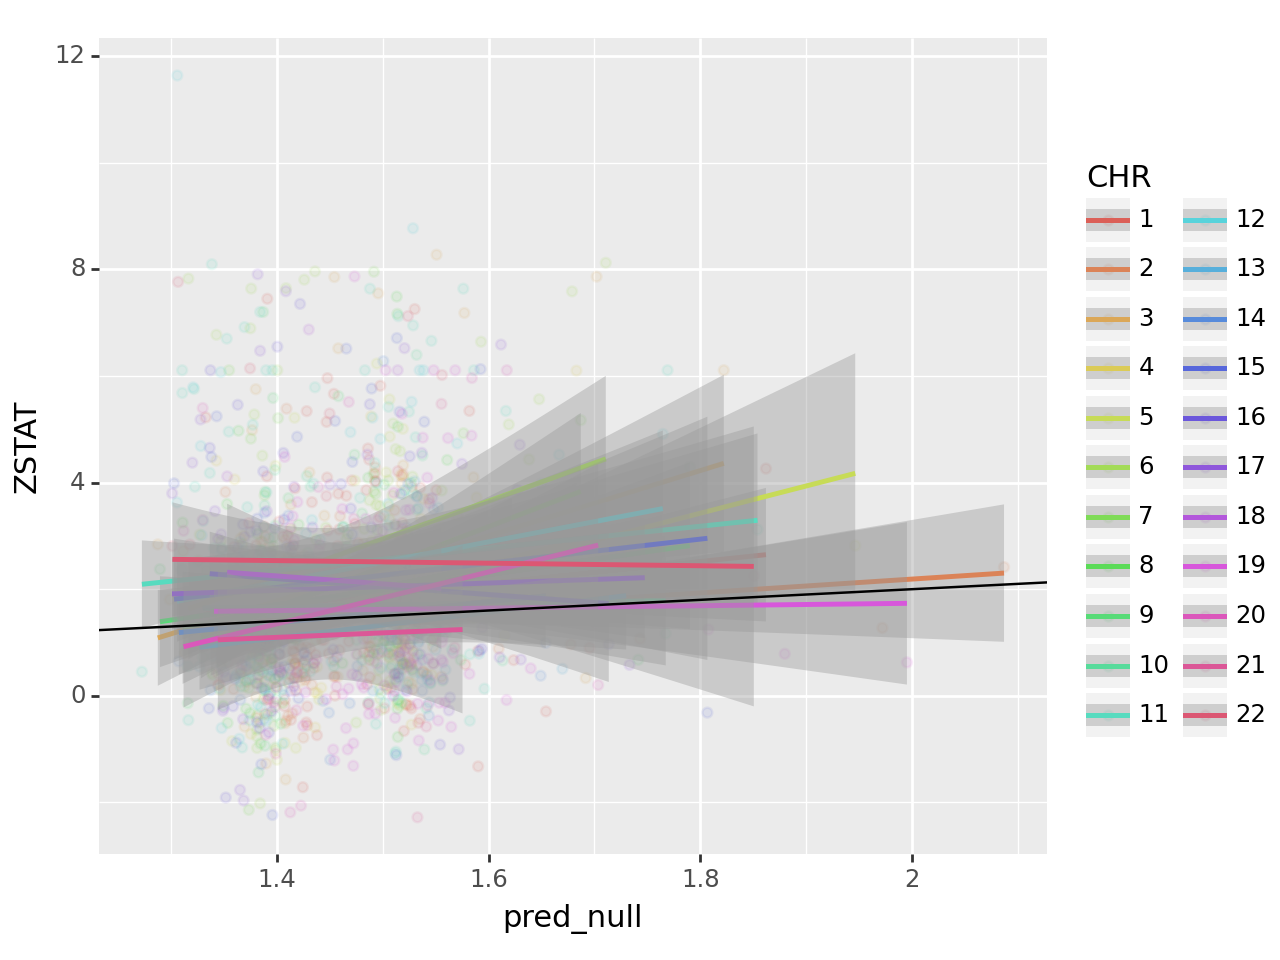

<Figure Size: (640 x 480)>

In [19]:
scatter(df, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = "CHR", smooth=True)

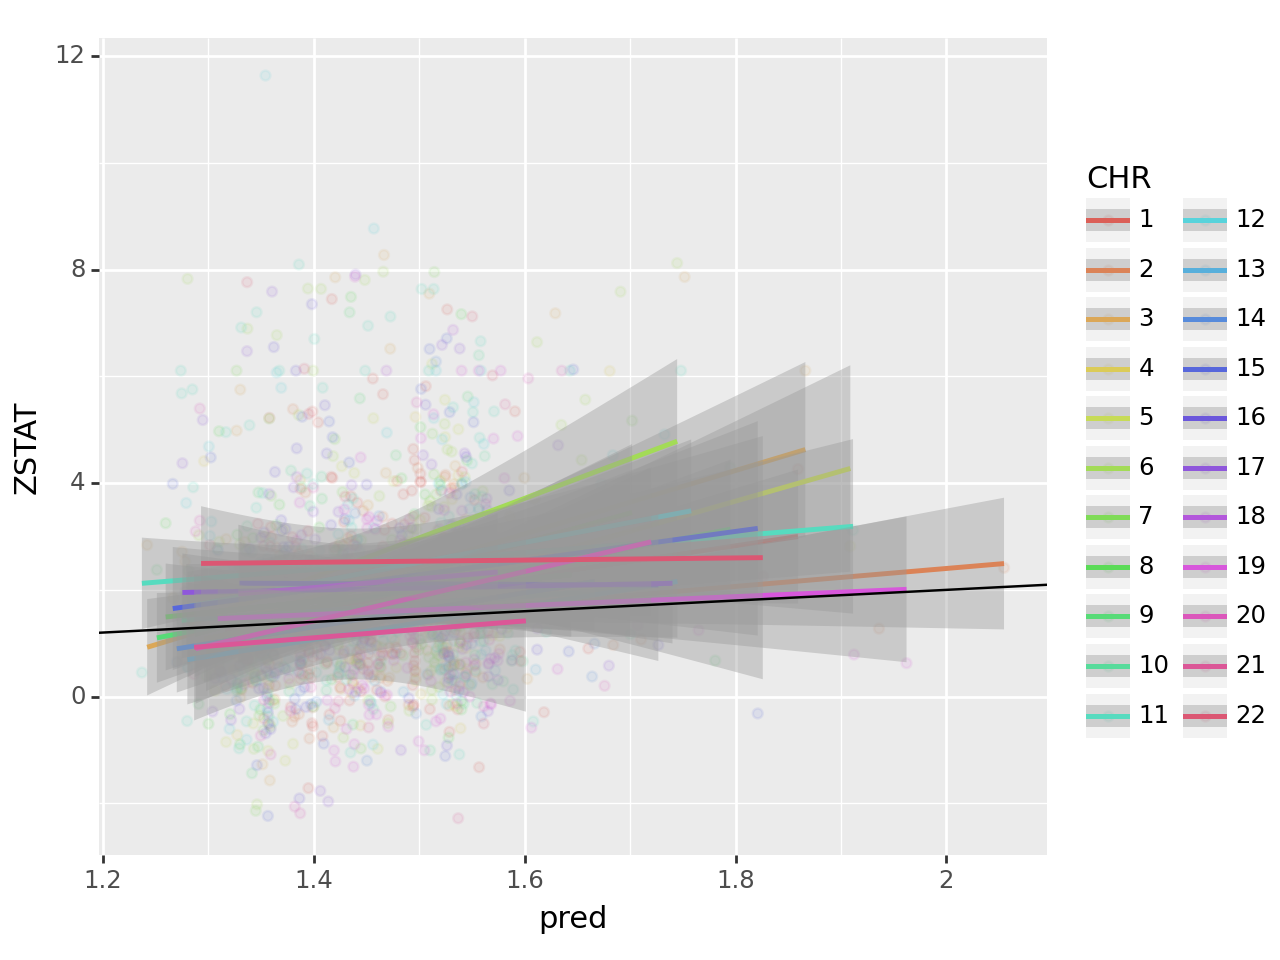

<Figure Size: (640 x 480)>

In [20]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = "CHR", smooth=True)

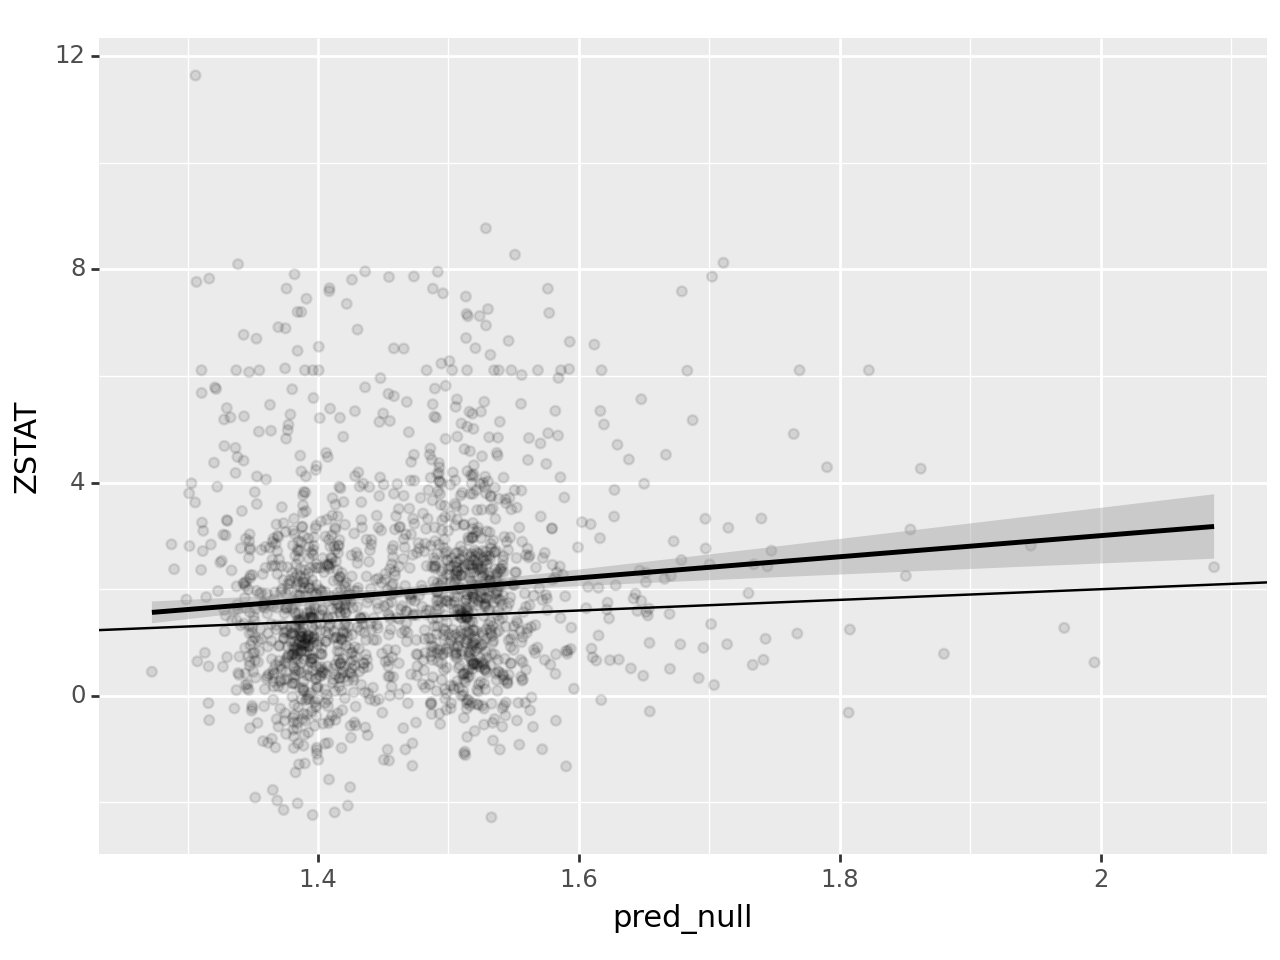

<Figure Size: (640 x 480)>

In [21]:
scatter(df, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = None, smooth=True)

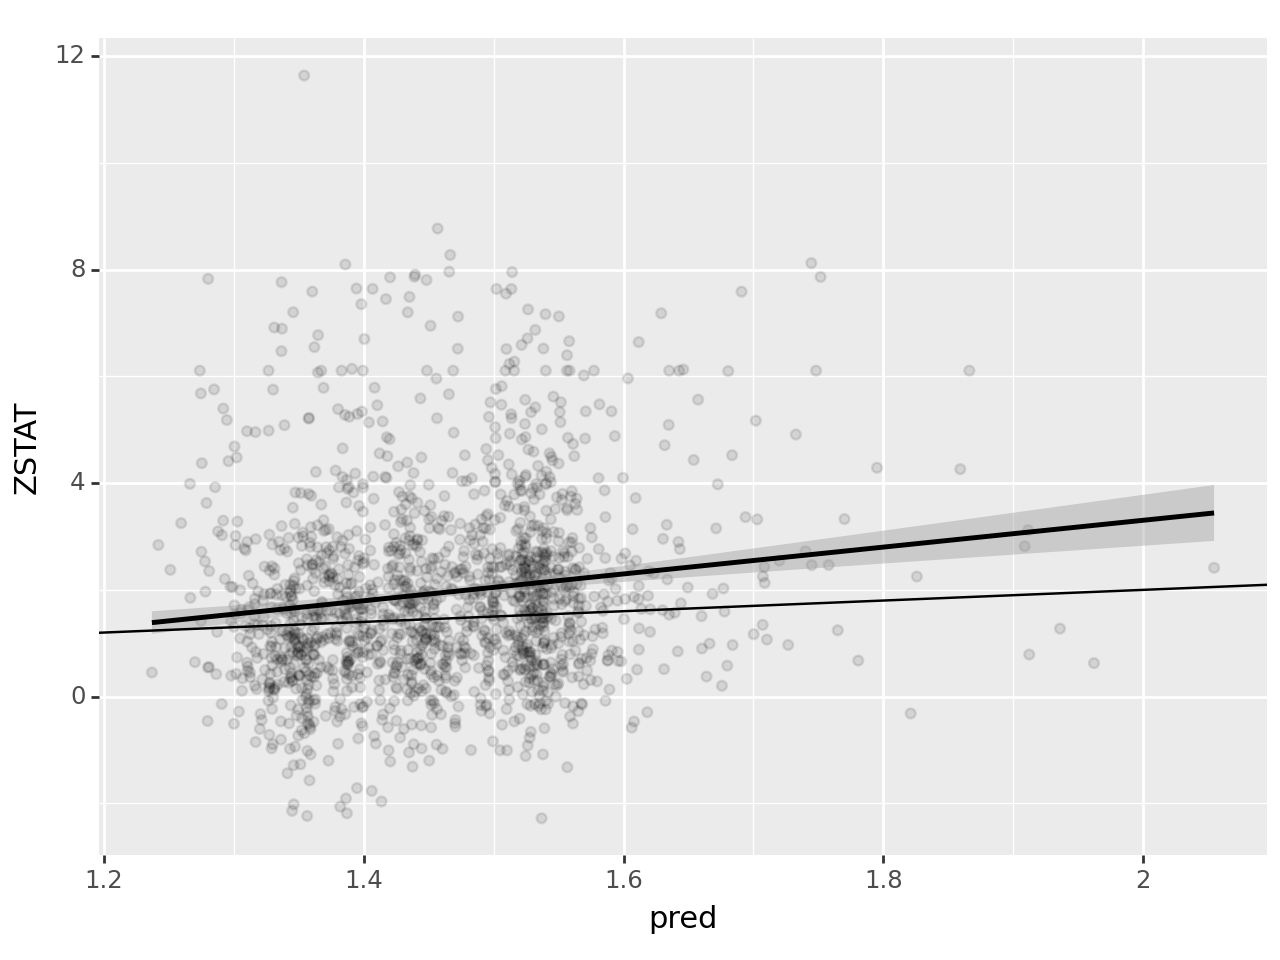

<Figure Size: (640 x 480)>

In [22]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = None, smooth=True)

In [23]:
#plot the r score
def plot_r2(dataframe=None, true = "ZSTAT", null = "pred_null", full="pred", r2_null=None, r2_full=None):
    if dataframe is not None:
        r2_null=[]
        r2_full=[]
        for i in range(1,23):
            df = dataframe.query("CHR == @i")
            r2_null.append(R2Score().update(torch.tensor(df[null].values), torch.tensor(df[true].values)).compute().numpy())
            r2_full.append(R2Score().update(torch.tensor(df[full].values), torch.tensor(df[true].values)).compute().numpy())
    r2 = pd.DataFrame({
        "r2_null": np.array(r2_null),
        "r2_full": np.array(r2_full),
        "r2_delta": (np.array(r2_full) - np.array(r2_null))})
    df1 = pd.melt(r2, value_vars=["r2_null", "r2_full"], var_name="model", value_name="r2")
    p1 = ggplot(df1, aes("model","r2")) + geom_boxplot()
    p2 = ggplot(r2, aes("r2_delta")) + geom_histogram()
    return p1, p2

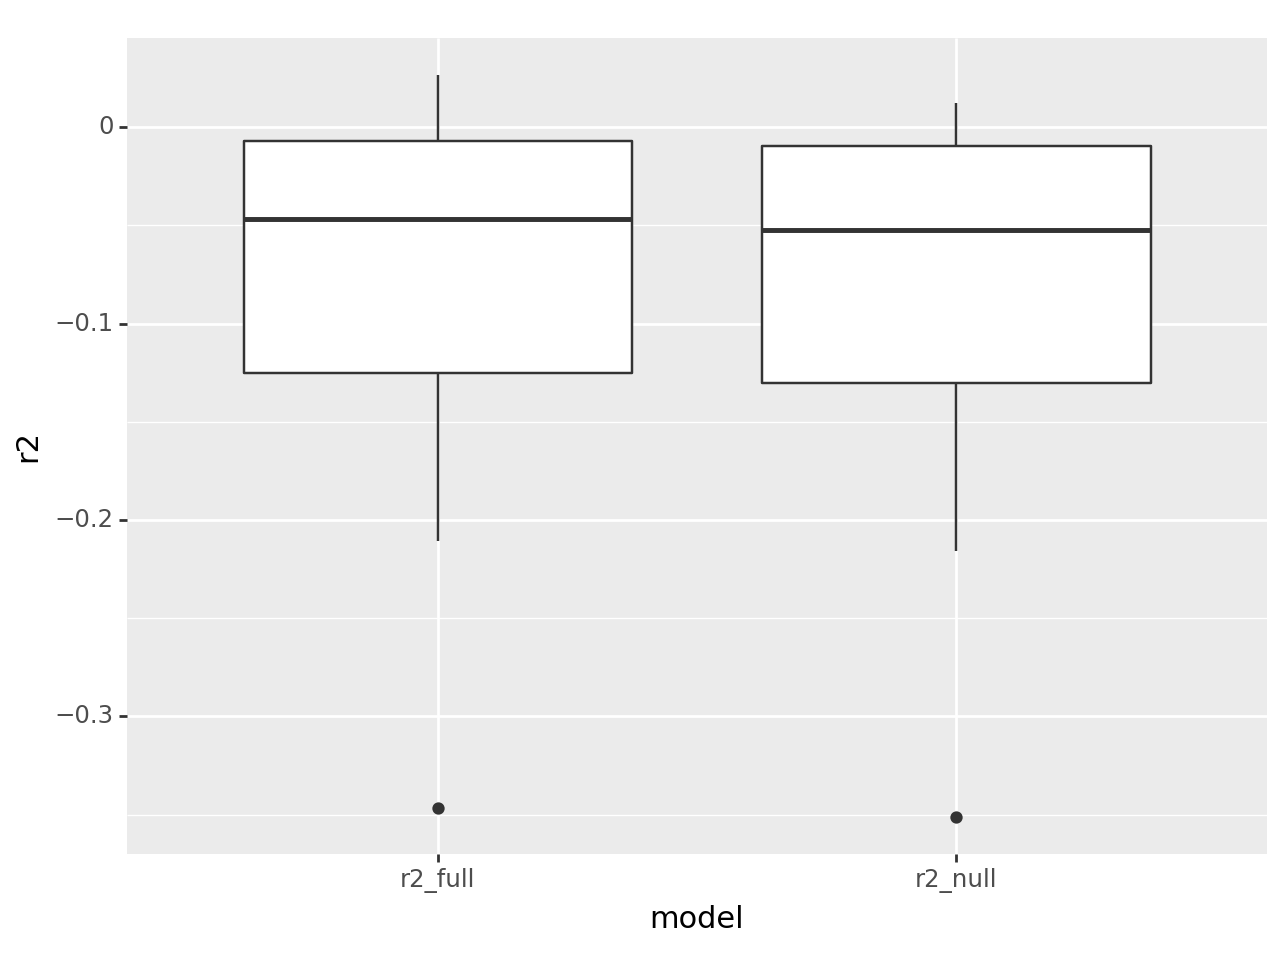

/home/niklas/Documents/TUM/5-WS2324/SysGen/Project/repo/notebooks/venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


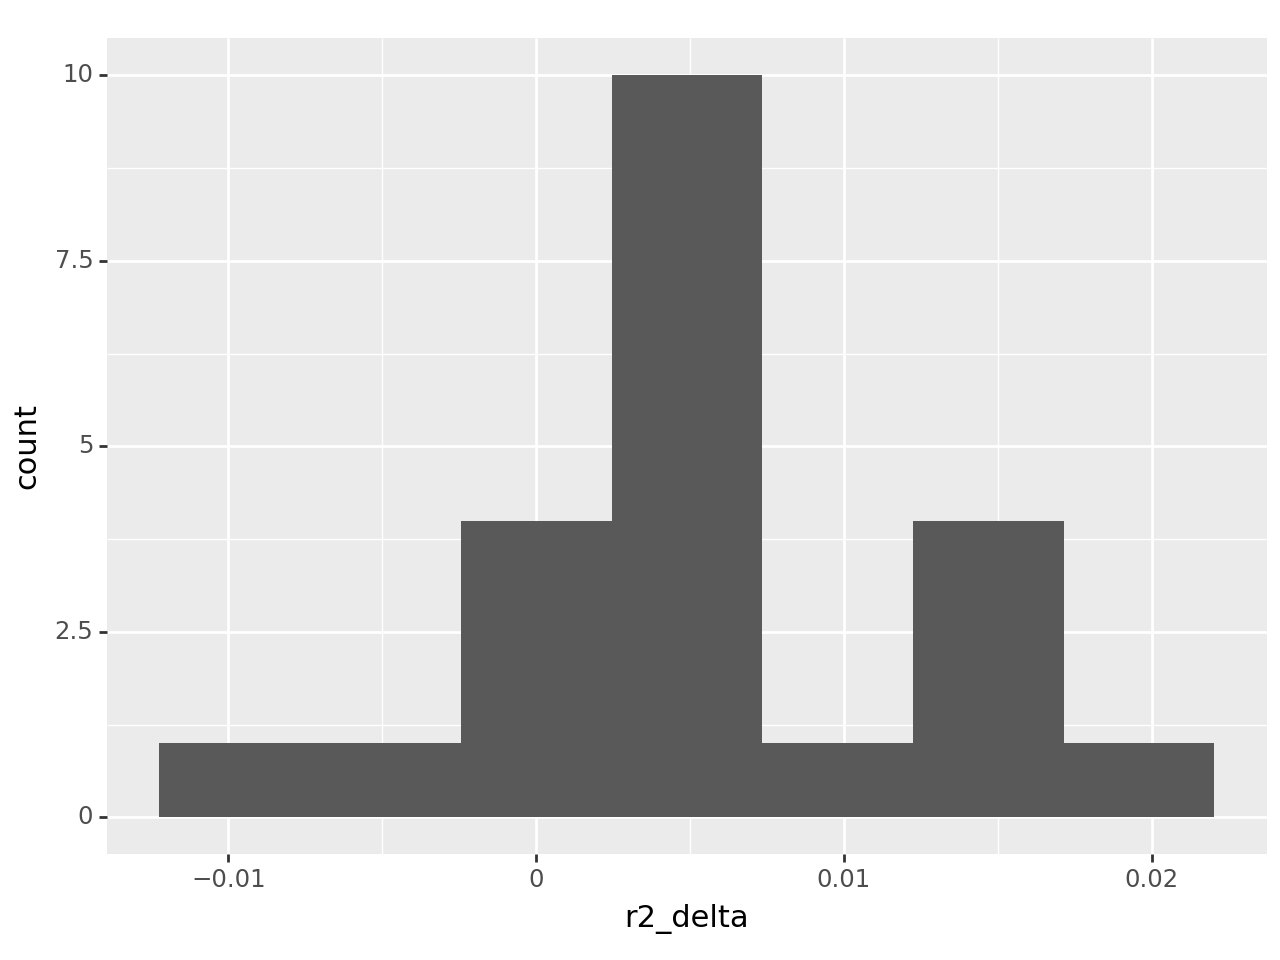

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [24]:
plot_r2(df)